In [1]:
import pandas as pd

df = pd.read_csv('../datas/softwareheritage.csv', encoding='latin-1', header=None, names=['program', 'sha', 'tags', 'readme'])

df.head()

program                                       sha  \
0         0install  8ab8d948d312fcbbe52a625525477e80ef39316d   
1            2ping  641f949c513d062577a73b3eac67ac67210d6884   
2           2vcard  b8e169e06e1fa1bacfa18b3037205b04cf7c3db3   
3           389-ds  3e53c86273d3c1175e95a4428d90f03e103c5488   
4  389-ds-base-dev  3e53c86273d3c1175e95a4428d90f03e103c5488   

                                                tags  \
0                                     uitoolkit::gtk   
1  role::program,interface::commandline,scope::ut...   
2  role::program,implemented-in::perl,use::conver...   
3  security::authentication,role::metapackage,sys...   
4                     devel::library,role::devel-lib   

                                              readme  
0  0install\n========\n\nCopyright Thomas Leonard...  
1  2ping, a bi-directional ping utility\nBy Ryan ...  
2  The 2vcard Handbook\n\nJan Schaumann jschauma@...  
3  ==============================================...  
4  ==============================================...

In [2]:
df['readme'] = df['readme'].str.replace('\\n',' ', regex=True) 
df.head()

program                                       sha  \
0         0install  8ab8d948d312fcbbe52a625525477e80ef39316d   
1            2ping  641f949c513d062577a73b3eac67ac67210d6884   
2           2vcard  b8e169e06e1fa1bacfa18b3037205b04cf7c3db3   
3           389-ds  3e53c86273d3c1175e95a4428d90f03e103c5488   
4  389-ds-base-dev  3e53c86273d3c1175e95a4428d90f03e103c5488   

                                                tags  \
0                                     uitoolkit::gtk   
1  role::program,interface::commandline,scope::ut...   
2  role::program,implemented-in::perl,use::conver...   
3  security::authentication,role::metapackage,sys...   
4                     devel::library,role::devel-lib   

                                              readme  
0  0install ========  Copyright Thomas Leonard an...  
1  2ping, a bi-directional ping utility By Ryan F...  
2  The 2vcard Handbook  Jan Schaumann jschauma@ne...  
3  ==============================================...  
4  ==============================================...

### Creating correspondance matrices for each entity type

The dataframe that we just read consists of articles as rows with their id, title, text and url as columns.

From this table of articles, we want to extract two matrices representing the articles and their words.

In [5]:
from cartodata.loading import load_text_column
from sklearn.feature_extraction import text as sktxt

with open('../datas/stopwords.txt', 'r') as stop_file:
    stopwords = sktxt.ENGLISH_STOP_WORDS.union(set(stop_file.read().splitlines()))

words_mat, words_scores = load_text_column(df, 'readme', 4, 25, 0.1, stopwords=stopwords)
words_scores.head()

000000                         91
000000 color                   35
000000 color default           34
000000 color default 00af00    34
0000af                         34
dtype: int64

In [6]:
from cartodata.operations import normalize_tfidf

words_mat = normalize_tfidf(words_mat)
words_mat.shape

(20563, 28420)

In [7]:
from cartodata.loading import load_identity_column

articles_mat, articles_scores = load_identity_column(df, 'program')
articles_scores.head()

0install           1.0
2ping              1.0
2vcard             1.0
389-ds             1.0
389-ds-base-dev    1.0
dtype: float64

In [8]:
from cartodata.loading import load_comma_separated_column

tags_mat, tags_scores = load_comma_separated_column(df, 'tags')
tags_scores.head()

uitoolkit::gtk            1704
role::program             5749
interface::commandline    2081
scope::utility            2354
implemented-in::perl      3526
dtype: int64

### Dimension reduction

In [9]:
from cartodata.projection import lsa_projection
from cartodata.operations import normalize_l2

lsa_matrices = lsa_projection(200, words_mat, [articles_mat, tags_mat, words_mat])
lsa_matrices = list(map(normalize_l2, lsa_matrices))

### UMAP projection

In [10]:
from cartodata.projection import umap_projection

umap_matrices = umap_projection(lsa_matrices)

/Users/jonas/anaconda3/envs/cartodata/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 30 separate connected components using meta-embedding (experimental)
  n_components


### Plot


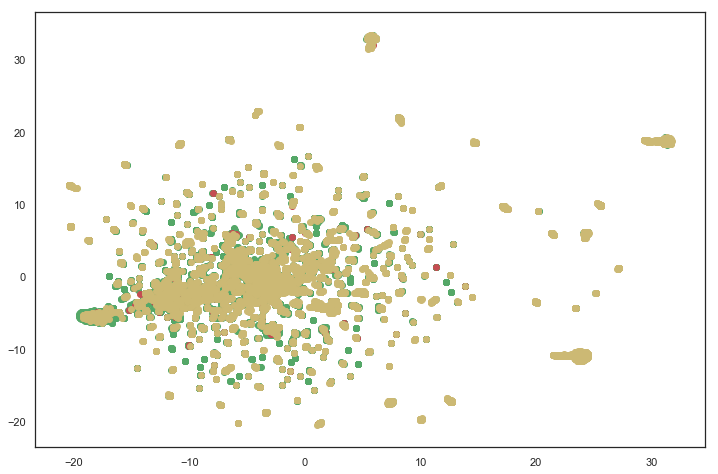

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn as sns
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(12,8)})

colors = ['g', 'r', 'y']

fig, ax = plt.subplots()
for i, m in enumerate(umap_matrices):
    ax.scatter(m[0, :], m[1, :], color=colors[i])